In [1]:
#env used: bbVV

from typing import List
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import os

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 20})

In [2]:
MAIN_DIR = "../"

plot_dir = f"{MAIN_DIR}/plots/bias_test/31Jan24"
_ = os.system(f"mkdir -p {plot_dir}")

In [69]:
# biases = [0.0, 0.15, 0.3, 1.0]
biases = ["0","1","0p3","0p6","3","5"]
biases = ["0","1","0p6"]
bias_dict = {
    "0":0,
    "1":1,
    # "0p3":0.3,
    "0p6":0.6,
    # "3":3,
    # "5":5
}
r_dict = {}
for bias in biases:
    file = uproot.concatenate(
        f"/home/pku/zhaoyz/Higgs/boostedHWW/combine/bias_test/cards/scale{bias}/higgsCombinebias{bias_dict[bias]}.FitDiagnostics.mH125.*.root"
    )
    r = np.array(file.limit)[::4]
    reldiff = np.std(r)
    r_dict[bias] = {
        "r": r, #best fit signal strength
    }

In [63]:
r_dict["1"]

{'r': array([ 1.58894659e+00,  2.31892354e+00,  2.03212864e+00,  1.75652179e+00,
         2.31972153e+00,  1.35297432e+00, -1.81336780e+00,  1.62295525e+00,
         1.04716083e+00,  1.57254561e-02,  2.70154068e+00,  1.40638412e+00,
         2.44061346e+00,  1.59974332e+00,  1.62658429e+00,  1.35105196e+00,
         1.29258458e+00,  2.73720037e-01,  1.93986267e+00,  1.80110417e+00,
         1.27497985e+00,  2.55041194e+00, -1.32703742e+00,  1.26088949e+00,
        -1.05279651e+00, -1.30236590e+00,  1.55930145e+00,  2.57694056e+00,
        -9.06248935e-02, -4.38057062e-02,  2.89591456e+00,  3.95042337e+00,
         1.56928453e+00,  2.62565960e+00, -2.51773415e+00,  8.44512886e-01,
        -3.09186925e-01,  3.15759339e+00,  1.22320335e+00,  9.87986340e-01,
         5.63167858e-01,  2.41090058e+00,  4.95601933e-01,  1.18842997e+00,
        -1.76998333e+00,  1.86994263e+00, -4.57904255e-01,  3.19183683e+00,
        -1.26386545e+00,  1.50967068e+00, -7.10875641e-01,  2.09038491e+00,
       

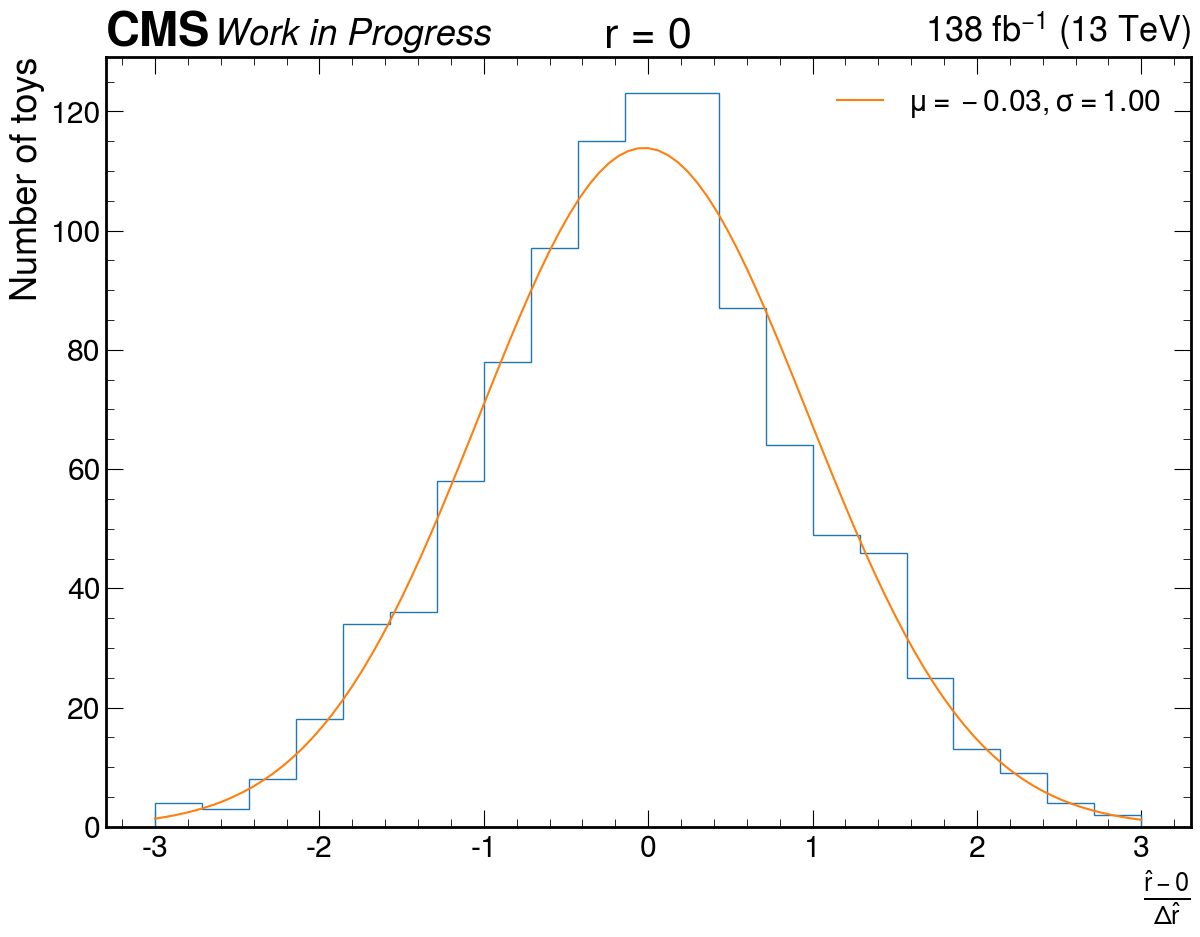

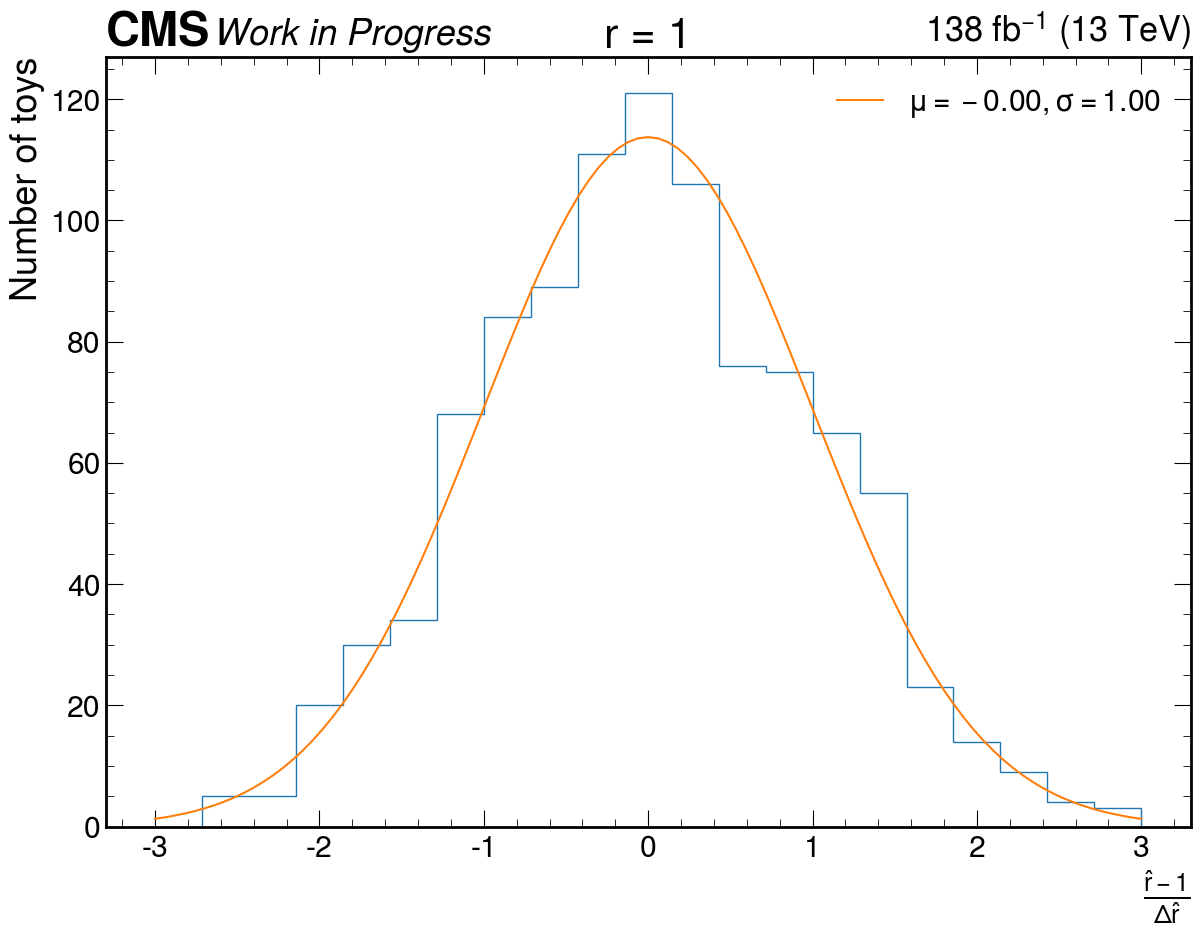

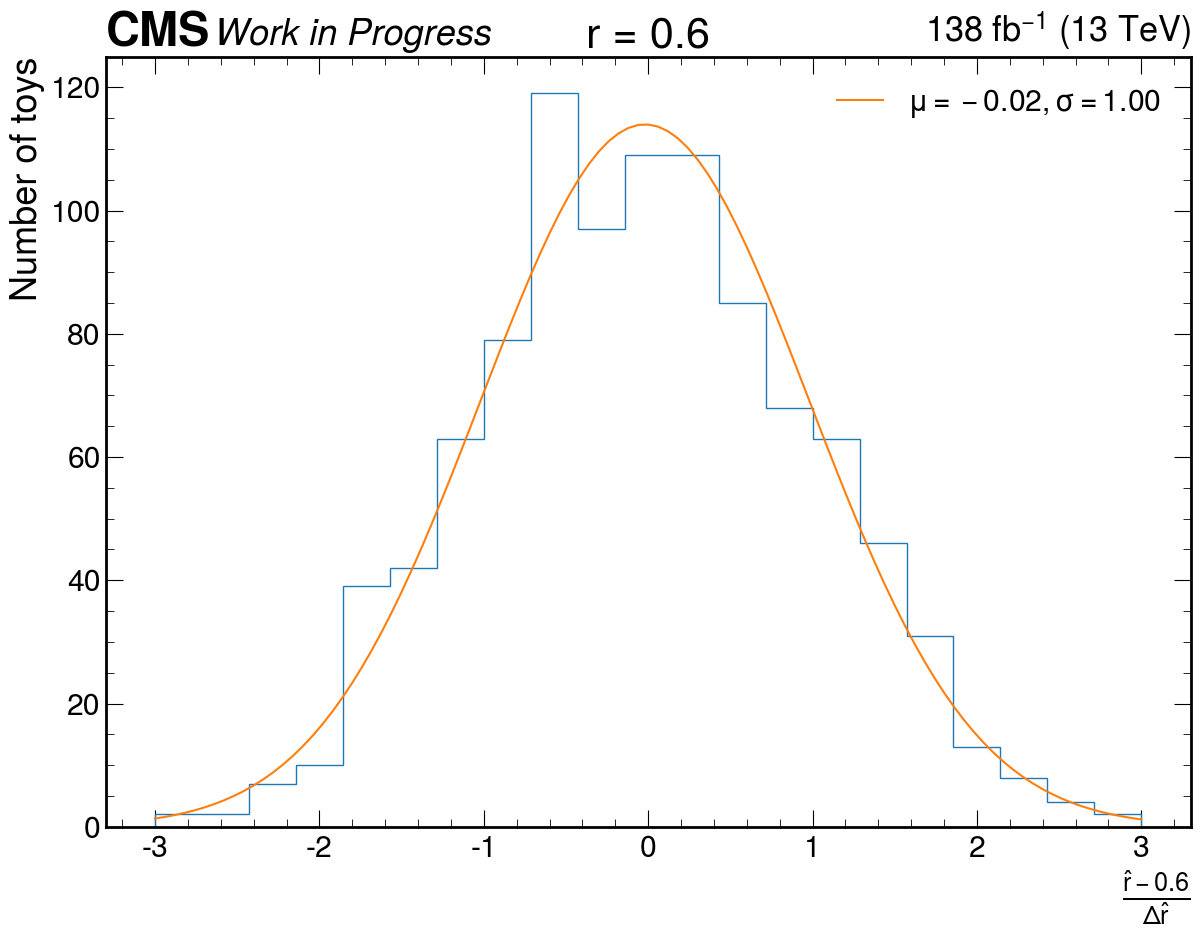

In [71]:
#plot the bias plots
from scipy import stats
xrange = 3
bins = 21
x = np.linspace(-xrange, xrange, 101)
# fig, ax = plt.subplots(len(biases), 1, figsize=(12, 40))
for i, bias in enumerate(biases):
    hep.style.use("CMS")
    plt.figure(figsize=(14, 10))
    ax = plt.gca()
    r = r_dict[bias]["r"]
    var_plot = (r - bias_dict[bias])/np.std(r)
    mu, sigma = np.mean(var_plot), np.std(var_plot)
    ax.hist(var_plot, np.linspace(-xrange, xrange, bins + 1), histtype="step")
    ax.plot(
        x,
        # scale by bin width
        stats.norm.pdf(x, loc=mu, scale=sigma) * len(r) * (2 * xrange / bins),
        label=rf"$\mu = {mu:.2f}, \sigma = {sigma:.2f}$",
    )
    ax.set_xlabel(rf"$\frac{{\hat{{r}} - {bias_dict[bias]}}}{{\Delta \hat r}}$")
    ax.set_ylabel("Number of toys")
    ax.set_title(f"r = {bias_dict[bias]}")
    ax.legend()
    hep.cms.label(
        "Work in Progress",
        ax=ax,
        data=True,
        lumi=138,
        year=None,
    )
    plt.savefig(f"{plot_dir}/bias_test_plots_{bias}.pdf", bbox_inches="tight")
    plt.show()